contour level [ 0.5]
number of contour path 1
len(Z) 437
Shape of Z (437,)
Nyquist index 218
Number of components from both sides: 10 10
<type 'numpy.ndarray'>
(437,)
len(Z_filt) 437
contour level [ 0.5]
number of contour path 1
len(Z) 817
Shape of Z (817,)
Nyquist index 408
Number of components from both sides: 10 10
<type 'numpy.ndarray'>
(817,)
len(Z_filt) 817
contour level [ 0.5]
number of contour path 2
len(Z) 243
Shape of Z (243,)
Nyquist index 121
Number of components from both sides: 10 10
<type 'numpy.ndarray'>
(243,)
len(Z_filt) 243


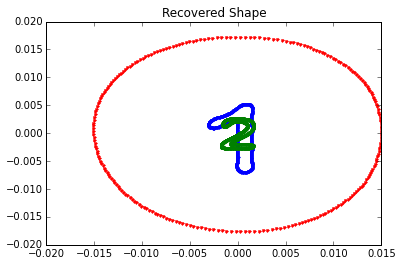

In [28]:
%matplotlib inline
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
#from skimage import feature

def extract_shape(im_file, blowup = 1., plot_img = False, plot_contour = False, plot_contour_pts = False):
    x_arr = []
    y_arr = []
    im = mpimg.imread(im_file)
    # Take one of RGB(A) channels
    if len(im.shape) > 2:
        im = im[:, :, 0]
    
    if plot_img:
        plt.figure()
        plt.title('Original Shape')
        plt.imshow(im, cmap = plt.cm.gray)

    # Note: by convention, in this case, y values comes from the 0th index.
    # Otherwise one has to transpose the image and the contour will appear sideways 
    x = np.arange(im.shape[1])*blowup  
    y = np.arange(im.shape[0])*blowup
    
    # Have to flip y to get the orientation right, again just a peculiar convention we have to work around
    # Note the [::] notation: a[3:20:2] means from the 3rd element to the 20th element, choose every 2nd element.
    y = y[::-1]

    # In case I want to shift x.
    #x_shift = 200
    #x += x_shift

    X, Y = np.meshgrid(x, y)
    
    plt.figure()
    plt.title('Contours')
    # Note the dimensions of x and y may NOT the same, thus the necessity of the 
    # tranpose operation (an oddity, I admit...)
    CS = plt.contour(X, Y, im, 1)
    levels = CS.levels
    print 'contour level', levels
    if not plot_contour:
        plt.close()

    cs_paths = CS.collections[0].get_paths()

    print 'number of contour path', len(cs_paths)

    for i in range(0, len(cs_paths)):
        v = cs_paths[i].vertices
        x_arr.append(v[:,0])
        y_arr.append(v[:,1])

    if plot_contour_pts:
        plt.figure()
        plt.title("Verify the contour points are correct")
        for i in range(0, len(cs_paths)):
            plt.scatter(x_arr[i], y_arr[i])

    return x_arr, y_arr, cs_paths

def FD(x, y, plot_FD = False, y_lim = None):
    N = len(x)
    n = np.arange(N)
    z = x + y*1j
    Z = np.fft.fft(z)
    if plot_FD:
        plt.figure()
        plt.title('FD real and imag')
        plt.plot(Z.real, 'b-')
        plt.plot(Z.imag, 'g-')
        if y_lim != None:
            plt.ylim([-y_lim, y_lim])
    return Z
    
def filt_FD(Z, n_keep, no_zeroth = True):
    N = len(Z)
    n = np.arange(len(Z))
    print 'Nyquist index', N/2
    # in case I want the centroid position.
    filt0 = n > 0 if no_zeroth else 1
    filt1 = filt0*(n <= n_keep)
    
    filt2 = (n > ((N-1) - n_keep))
    print 'Number of components from both sides:', filt1.sum(), filt2.sum()
    filt = filt1 + filt2
    #print Z.real[N/2]
    return Z*filt
    
def get_FD_abs(x, y, order = 10, norm = True, no_zeroth = True):
    '''Finds the Fourier Descriptors and the recovered x and y for a shape.'''
    Z = []
    for i in range(0, len(cs_paths)):
        Z = FD(x[i], y[i])
    print 'len(Z)', len(Z)
    print 'Shape of Z', Z.shape

    Z_filt = filt_FD(Z, order, no_zeroth=no_zeroth)
    if norm:
        print type(Z_filt)
        print Z_filt.shape
        Z_filt = size_norm(Z_filt)
    print 'len(Z_filt)', len(Z_filt)
    x_rec, y_rec = recover_shape(Z_filt)

    # throw away zero terms
    fd_mag = np.abs(Z_filt[Z_filt != 0])
#     fd_mag = fd_mag[fd_mag > 0]
    
    return fd_mag, x_rec, y_rec

def recover_shape(Z):
    z_rec = np.fft.ifft(Z)
    x_rec = z_rec.real
    y_rec = z_rec.imag
    return x_rec, y_rec
    
def size_norm(Z):
    return Z/np.sqrt(np.abs(Z[1])*np.abs(Z[-1]))
    
def plot_shape(x, y, ax = 0, plot_style = 'b.', new_plot = False):
    if new_plot == True:
        fig, ax = plt.subplots()
        ax.set_title('Recovered Shape')
    try:
        xlen = len(x)
    except:
        ax.plot(x, y, plot_style)
    else:
        for i in range(xlen):
            ax.plot(x[i], y[i], plot_style)
    return ax
    
    
x1, y1, cs_paths = extract_shape('number1.png')
fd_mag, x_rec, y_rec = get_FD_abs(x1,y1)
ax = plot_shape(x_rec, y_rec, new_plot = True)
x2, y2, cs_paths = extract_shape('number2.png')
fd_mag2, x_rec2, y_rec2 = get_FD_abs(x2,y2)
plot_shape(x_rec2, y_rec2, ax, 'g.')
x3, y3, cs_paths = extract_shape('number6.png', .1)
fd_mag3, x_rec3, y_rec3 = get_FD_abs(x3,y3)
plot_shape(x_rec3, y_rec3, ax, 'r.')